# COVID-19: Time Series Prediction

In [64]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Statements

In [2]:
import warnings
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x

import torch
from torch import nn, optim
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import tensorflow as tf
# from tensorflow import set_random_seed
from numpy.random import seed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# print(tf.__version__)

In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
# set_random_seed(1)
seed(1)
torch.manual_seed(1)

## Loading the data

In [5]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/Dataset/newdata.csv', parse_dates=['Date'])
df.head()

,Unnamed: 0,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.0,0.0,0.0
1,1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.0,0.0,0.0
2,2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.0,0.0,0.0
3,3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.0,0.0,0.0
4,4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.0,0.0,0.0


## Data Preprocessing

In [6]:
df['Recovered'].fillna(0,inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.0,0.0,0.0
1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.0,0.0,0.0
2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.0,0.0,0.0
3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.0,0.0,0.0
4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.0,0.0,0.0


In [0]:
scaler = MinMaxScaler()
df[['Confirmed', 'Deaths', 'Recovered']] = scaler.fit_transform((df[['Confirmed', 'Deaths', 'Recovered']]))

In [0]:
train_date = []
test_date = []
t = pd.Timestamp(year=2020,month=3,day=3)

for i in range(len(df['Date'])):    
#     print((pd.Timestamp(df.iloc[i,4]) - t).days)
    if (pd.Timestamp(df.iloc[i,4]) - t).days >=0:
#         print(df.iloc[i,4])
        train_date.append(df.iloc[i,4])
    else:
#         print(df.iloc[i,4])
        test_date.append(df.iloc[i,4])

In [9]:
test = {'Province/State':[],
         'Country':[],
         'latitude':[],
         'longitude':[],
         'Date':[],
         'loc_id':[],
         'Key':[],
         'Confirmed':[],
         'Deaths':[],
         'Recovered':[]}
for i in range(len(df)):
    if df.iloc[i,4] in train_date:
        test['Province/State'].append(df.iloc[i,0])
        test['Country'].append(df.iloc[i,1])
        test['latitude'].append(df.iloc[i,2])
        test['longitude'].append(df.iloc[i,3])
        test['Date'].append(df.iloc[i,4])
        test['loc_id'].append(df.iloc[i,5])
        test['Key'].append(df.iloc[i,6])
        test['Confirmed'].append(df.iloc[i,7])
        test['Deaths'].append(df.iloc[i,8])
        test['Recovered'].append(df.iloc[i,9])

test = pd.DataFrame(test)
test.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-03-03,0,41,0.000498,0.003676,0.009469
1,Not specified,Afghanistan,33.0,65.0,2020-03-04,0,42,0.000498,0.003676,0.009469
2,Not specified,Afghanistan,33.0,65.0,2020-03-05,0,43,0.000498,0.003676,0.009469
3,Not specified,Afghanistan,33.0,65.0,2020-03-06,0,44,0.000498,0.003676,0.009469
4,Not specified,Afghanistan,33.0,65.0,2020-03-07,0,45,0.000498,0.003676,0.009469


In [10]:
train = {'Province/State':[],
         'Country':[],
         'latitude':[],
         'longitude':[],
         'Date':[],
         'loc_id':[],
         'Key':[],
         'Confirmed':[],
         'Deaths':[],
         'Recovered':[]}
for i in range(len(df)):
    if df.iloc[i,4] in test_date:
        train['Province/State'].append(df.iloc[i,0])
        train['Country'].append(df.iloc[i,1])
        train['latitude'].append(df.iloc[i,2])
        train['longitude'].append(df.iloc[i,3])
        train['Date'].append(df.iloc[i,4])
        train['loc_id'].append(df.iloc[i,5])
        train['Key'].append(df.iloc[i,6])
        train['Confirmed'].append(df.iloc[i,7])
        train['Deaths'].append(df.iloc[i,8])
        train['Recovered'].append(df.iloc[i,9])

train = pd.DataFrame(train)
train.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.000498,0.003676,0.009469
1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.000498,0.003676,0.009469
2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.000498,0.003676,0.009469
3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.000498,0.003676,0.009469
4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.000498,0.003676,0.009469


In [11]:
print('No. of rows in train and test:',train.shape[0], test.shape[0])

No. of rows in train and test: 10578 7998


In [12]:
print('Min date from train set: %s' % train['Date'].min().date())
print('Max date from train set: %s' % train['Date'].max().date())

Min date from train set: 2020-01-22
Max date from train set: 2020-03-02


In [13]:
lag_size = (test['Date'].max().date() - train['Date'].max().date()).days
print('Max date from train set: %s' % train['Date'].max().date())
print('Max date from test set: %s' % test['Date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2020-03-02
Max date from test set: 2020-04-02
Forecast lag size 31


In [0]:
daily_confirmed = train.groupby('Date', as_index=False)['Confirmed'].sum()
country_confirmed = train.groupby(['Country', 'Date'], as_index=False)['Confirmed'].sum()

daily_death = train.groupby('Date', as_index=False)['Deaths'].sum()
country_death = train.groupby(['Country', 'Date'], as_index=False)['Deaths'].sum()

daily_recovered = train.groupby('Date', as_index=False)['Recovered'].sum()
country_recovered = train.groupby(['Country', 'Date'], as_index=False)['Recovered'].sum()

In [15]:
train_gp = train.sort_values('Date').groupby(['Country', 'Date'], as_index=False)
train_gp = train_gp.agg({'Confirmed':['sum'],'Deaths':['sum'],'Recovered':['sum']})
train_gp.columns = ['Country', 'Date', 'Confirmed','Deaths','Recovered']
train_gp.head()
le = LabelEncoder()
train_gp['Country'] = le.fit_transform(train_gp['Country'])
train_gp.head()

,Country,Date,Confirmed,Deaths,Recovered
0,0,2020-01-22,0.000498,0.003676,0.009469
1,0,2020-01-23,0.000498,0.003676,0.009469
2,0,2020-01-24,0.000498,0.003676,0.009469
3,0,2020-01-25,0.000498,0.003676,0.009469
4,0,2020-01-26,0.000498,0.003676,0.009469


In [0]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()

    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
window = 30
lag = lag_size
series = series_to_supervised(train_gp.drop('Date', axis=1), window=window, lag=lag)
series.head()

,Country(t-30),Confirmed(t-30),Deaths(t-30),Recovered(t-30),Country(t-29),Confirmed(t-29),Deaths(t-29),Recovered(t-29),Country(t-28),Confirmed(t-28),Deaths(t-28),Recovered(t-28),Country(t-27),Confirmed(t-27),Deaths(t-27),Recovered(t-27),Country(t-26),Confirmed(t-26),Deaths(t-26),Recovered(t-26),Country(t-25),Confirmed(t-25),Deaths(t-25),Recovered(t-25),Country(t-24),Confirmed(t-24),Deaths(t-24),Recovered(t-24),Country(t-23),Confirmed(t-23),Deaths(t-23),Recovered(t-23),Country(t-22),Confirmed(t-22),Deaths(t-22),Recovered(t-22),Country(t-21),Confirmed(t-21),Deaths(t-21),Recovered(t-21),...,Country(t-8),Confirmed(t-8),Deaths(t-8),Recovered(t-8),Country(t-7),Confirmed(t-7),Deaths(t-7),Recovered(t-7),Country(t-6),Confirmed(t-6),Deaths(t-6),Recovered(t-6),Country(t-5),Confirmed(t-5),Deaths(t-5),Recovered(t-5),Country(t-4),Confirmed(t-4),Deaths(t-4),Recovered(t-4),Country(t-3),Confirmed(t-3),Deaths(t-3),Recovered(t-3),Country(t-2),Confirmed(t-2),Deaths(t-2),Recovered(t-2),Country(t-1),Confirmed(t-1),Deaths(t-1),Recovered(t-1),Country(t),Confirmed(t),Deaths(t),Recovered(t),Country(t+31),Confirmed(t+31),Deaths(t+31),Recovered(t+31)
30,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
31,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
32,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
33,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000532,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
34,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.00049

In [0]:
last_country = 'Country(t-%d)' % window
series = series[(series['Country(t)'] == series[last_country])]

In [0]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Recovered','Deaths']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Deaths','Recovered']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['Recovered(t)'], axis=1, inplace=True)
series.drop(['Deaths(t)'],axis = 1, inplace=True)

In [20]:
series.head()

,Country(t-30),Confirmed(t-30),Country(t-29),Confirmed(t-29),Country(t-28),Confirmed(t-28),Country(t-27),Confirmed(t-27),Country(t-26),Confirmed(t-26),Country(t-25),Confirmed(t-25),Country(t-24),Confirmed(t-24),Country(t-23),Confirmed(t-23),Country(t-22),Confirmed(t-22),Country(t-21),Confirmed(t-21),Country(t-20),Confirmed(t-20),Country(t-19),Confirmed(t-19),Country(t-18),Confirmed(t-18),Country(t-17),Confirmed(t-17),Country(t-16),Confirmed(t-16),Country(t-15),Confirmed(t-15),Country(t-14),Confirmed(t-14),Country(t-13),Confirmed(t-13),Country(t-12),Confirmed(t-12),Country(t-11),Confirmed(t-11),Country(t-10),Confirmed(t-10),Country(t-9),Confirmed(t-9),Country(t-8),Confirmed(t-8),Country(t-7),Confirmed(t-7),Country(t-6),Confirmed(t-6),Country(t-5),Confirmed(t-5),Country(t-4),Confirmed(t-4),Country(t-3),Confirmed(t-3),Country(t-2),Confirmed(t-2),Country(t-1),Confirmed(t-1),Country(t),Confirmed(t),Country(t+31),Confirmed(t+31)
30,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
31,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
32,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
33,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000532,1.0,0.000498
34,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000532,0,0.000498,1.0,0.000498


In [0]:
labels_col = 'Confirmed(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
# series = series.drop(columns = ['Recovered(t+%d)' % lag_size,'Deaths(t+%d)' % lag_size])

In [22]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (1584, 63)
Validation set shape (396, 63)


In [0]:
# columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Reco']]
# for i in range(window, 0, -1):
#     columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Country']]
# series.drop(columns_to_drop, axis=1, inplace=True)
# series.drop(['Country(t)'], axis=1, inplace=True)

In [0]:
train = train.groupby('Date').sum()
train = train.drop(columns=['latitude','longitude','loc_id','Key'],axis=1)

In [0]:
test = test.groupby('Date').sum()
test = test.drop(columns=['latitude','longitude','loc_id','Key'])

In [0]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(np.array(x))
        ys.append(np.array(y))
#     print('X',xs)
#     print('Y',ys)
    return np.array(xs), np.array(ys)

## Model Building

### Multilayer Perceptron Model

In [0]:
epochs = 20
batch = 4
lr = 0.0003
adam = optimizers.Adam(lr)

In [28]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(128,activation = 'relu'))
model_mlp.add(Dense(64,activation = 'relu'))
model_mlp.add(Dropout(lr*10))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
______________________________________________________________

In [46]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=1)

Train on 1584 samples, validate on 396 samples
Epoch 1/20
1584/1584 [==============================] - 1s 771us/step - loss: 14.6851 - val_loss: 1.8658
Epoch 2/20
1584/1584 [==============================] - 0s 105us/step - loss: 1.4954 - val_loss: 0.0081
Epoch 3/20
1584/1584 [==============================] - 0s 99us/step - loss: 1.3061 - val_loss: 0.0037
Epoch 4/20
1584/1584 [==============================] - 0s 104us/step - loss: 0.9077 - val_loss: 0.0066
Epoch 5/20
1584/1584 [==============================] - 0s 103us/step - loss: 0.4716 - val_loss: 0.0184
Epoch 6/20
1584/1584 [==============================] - 0s 101us/step - loss: 0.5229 - val_loss: 0.0433
Epoch 7/20
1584/1584 [==============================] - 0s 103us/step - loss: 0.3891 - val_loss: 0.0530
Epoch 8/20
1584/1584 [==============================] - 0s 98us/step - loss: 0.2763 - val_loss: 0.0110
Epoch 9/20
1584/1584 [==============================] - 0s 98us/step - loss: 0.2859 - val_loss: 0.0388
Epoch 10/20
1584/15

### Convolutional Neural Network

In [29]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1584, 63, 1)
Validation set shape (396, 63, 1)


In [34]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, kernel_size = 2, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, kernel_size = 2, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(64, kernel_size = 2, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(lr * 10))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 62, 64)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           16512     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 128)           32896     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 64)           

In [35]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)




Train on 1584 samples, validate on 396 samples
Epoch 1/20





1584/1584 [==============================] - 4s 3ms/step - loss: 1.5098 - val_loss: 0.1372
Epoch 2/20
1584/1584 [==============================] - 0s 161us/step - loss: 0.0984 - val_loss: 6.2008e-04
Epoch 3/20
1584/1584 [==============================] - 0s 159us/step - loss: 0.0510 - val_loss: 0.0071
Epoch 4/20
1584/1584 [==============================] - 0s 154us/step - loss: 0.0449 - val_loss: 9.7205e-05
Epoch 5/20
1584/1584 [==============================] - 0s 152us/step - loss: 0.0274 - val_loss: 0.0092
Epoch 6/20
1584/1584 [==============================] - 0s 153us/step - loss: 0.0294 - val_loss: 5.5820e-05
Epoch 7/20
1584/1584 [==============================] - 0s 168us/step - loss: 0.0170 - val_loss: 1.2868e-04
Epoch 8/20
1584/1584 [==============================] - 0s 163us/step - loss: 0.0124 - val_loss: 0.0061
Epoch 9/20
1584/1584 [==============================] - 0s 155us/step - loss: 0.0102 - val_loss: 7.

### Long Short-Term Memory

In [36]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True,activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(lr*10))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 63, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 63, 128)           98816     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 165,185
Trainable params: 165,185
Non-trainable params: 0
_________________________________________________________________


In [37]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1584 samples, validate on 396 samples
Epoch 1/20
1584/1584 [==============================] - 15s 9ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 2/20
1584/1584 [==============================] - 13s 8ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/20
1584/1584 [==============================] - 13s 8ms/step - loss: 0.0014 - val_loss: 8.7351e-04
Epoch 4/20
1584/1584 [==============================] - 13s 8ms/step - loss: 7.6070e-04 - val_loss: 4.6784e-04
Epoch 5/20
1584/1584 [==============================] - 13s 8ms/step - loss: 5.9210e-04 - val_loss: 2.5283e-04
Epoch 6/20
1584/1584 [==============================] - 13s 8ms/step - loss: 4.6219e-04 - val_loss: 3.3560e-04
Epoch 7/20
1584/1584 [==============================] - 13s 8ms/step - loss: 4.8952e-04 - val_loss: 8.4917e-04
Epoch 8/20
1584/1584 [==============================] - 13s 8ms/step - loss: 6.7359e-04 - val_loss: 0.

### CNN-LSTM Hybrid Model

In [38]:
subsequences = 3
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1584, 3, 21, 1)
Validation set shape (396, 3, 21, 1)


In [39]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences=True))
model_cnn_lstm.add(LSTM(128, activation='relu',return_sequences=True))
model_cnn_lstm.add(LSTM(64,activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)
model_cnn_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 21, 64)      128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10, 128)     8320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 5, 128)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 5, 64)       8256      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 128)        

In [0]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1)

### PyTorch

In [41]:
seq_length = 5
X_train_torch, y_train_torch = create_sequences(train.drop(columns=['Recovered','Deaths']), seq_length)
X_valid_torch, y_valid_torch = create_sequences(test.drop(columns=['Recovered','Deaths']), seq_length)

X_train_torch = torch.from_numpy(X_train_torch).float()
y_train_torch = torch.from_numpy(y_train_torch).float()

X_valid_torch = torch.from_numpy(X_valid_torch).float()
y_valid_torch = torch.from_numpy(y_valid_torch).float()

print('Train set shape', X_train_torch.shape)
print('Validation set shape', X_valid_torch.shape)

Train set shape torch.Size([35, 5, 1])
Validation set shape torch.Size([25, 5, 1])


In [0]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout= lr * 10
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [0]:
def train_model(model,train_data,train_labels,test_data=None,test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = epochs
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(1,num_epochs+1):
        model.reset_hidden_state()
        y_pred = model(X_train_torch)
        loss = loss_fn(y_pred.float(), y_train_torch)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_valid_torch)
                test_loss = loss_fn(y_test_pred.float(), y_valid_torch)
                test_hist[t-1] = test_loss.item()

            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t-1] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return model.eval(), train_hist, test_hist, y_pred, y_test_pred

In [44]:
torch_model = CoronaVirusPredictor( n_features=1,n_hidden=128,seq_len=seq_length,n_layers=4)
print(torch_model)
torch_model, train_hist, test_hist, y_pred, y_test_pred = train_model( torch_model, X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)

CoronaVirusPredictor(
  (lstm): LSTM(1, 128, num_layers=4, dropout=0.0029999999999999996)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch 10 train loss: 0.25659266114234924 test loss: 42.7035026550293
Epoch 20 train loss: 0.25160136818885803 test loss: 41.91297149658203


## Comparing Models

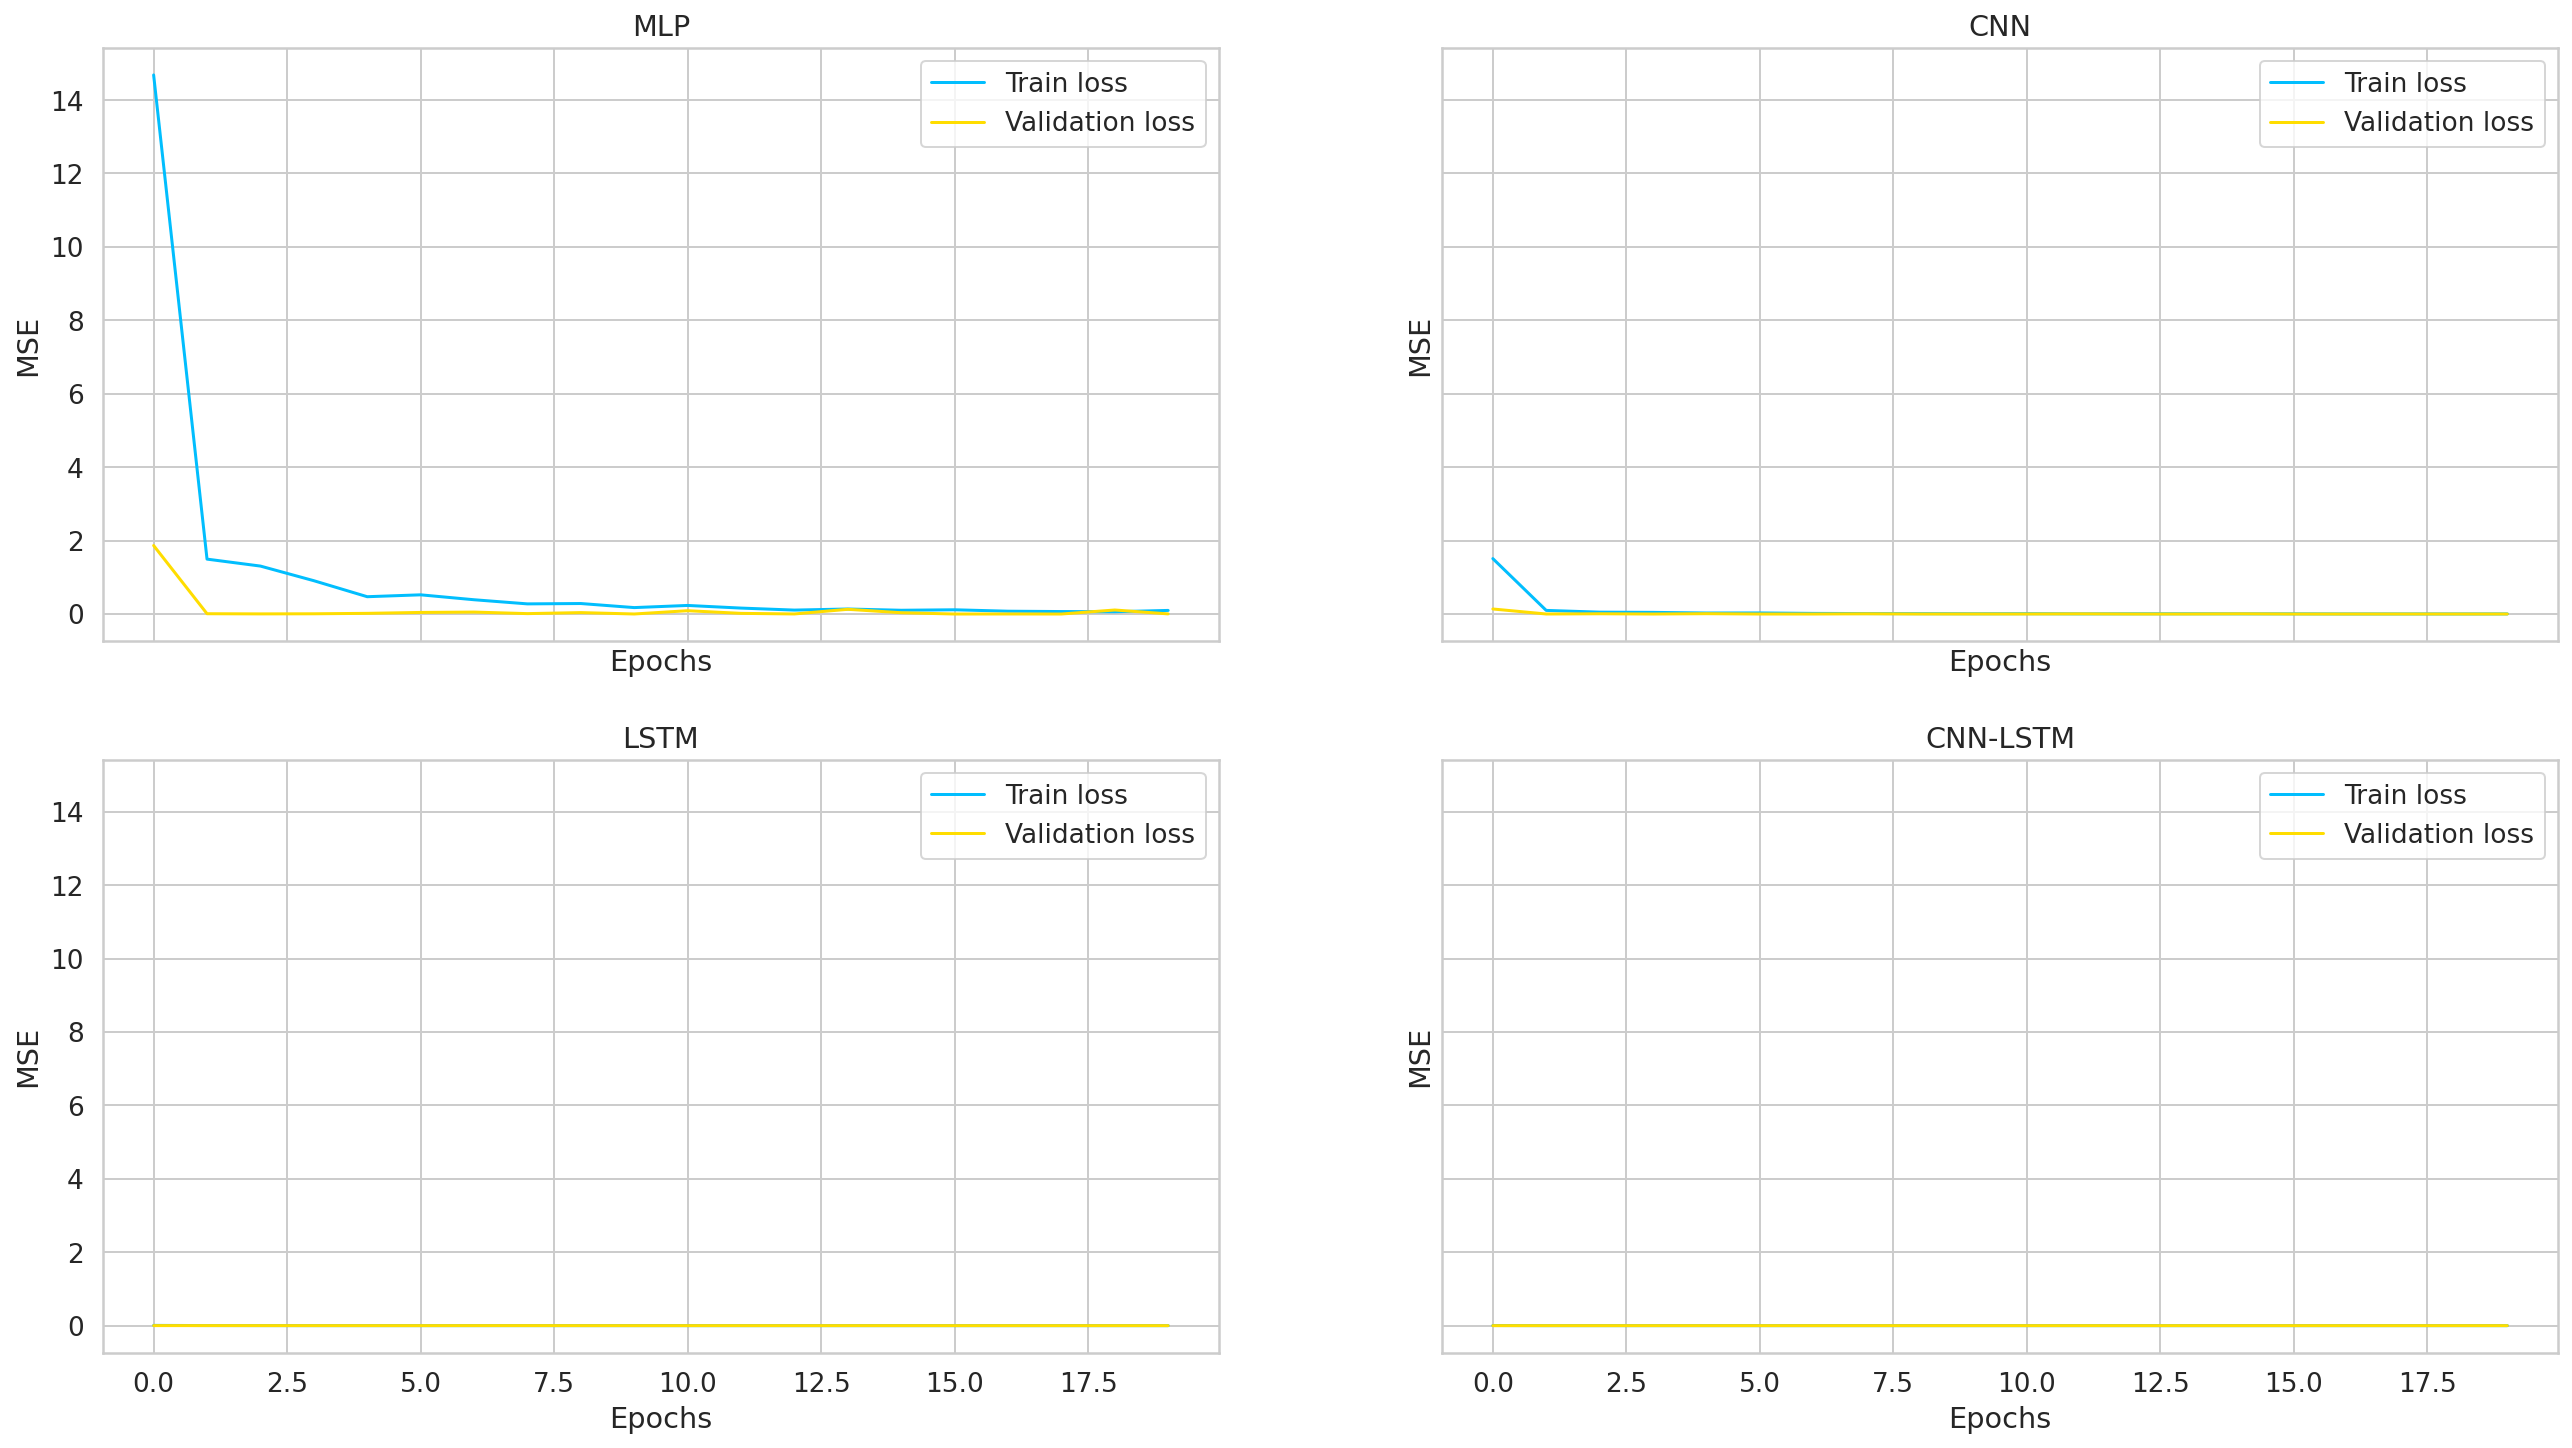

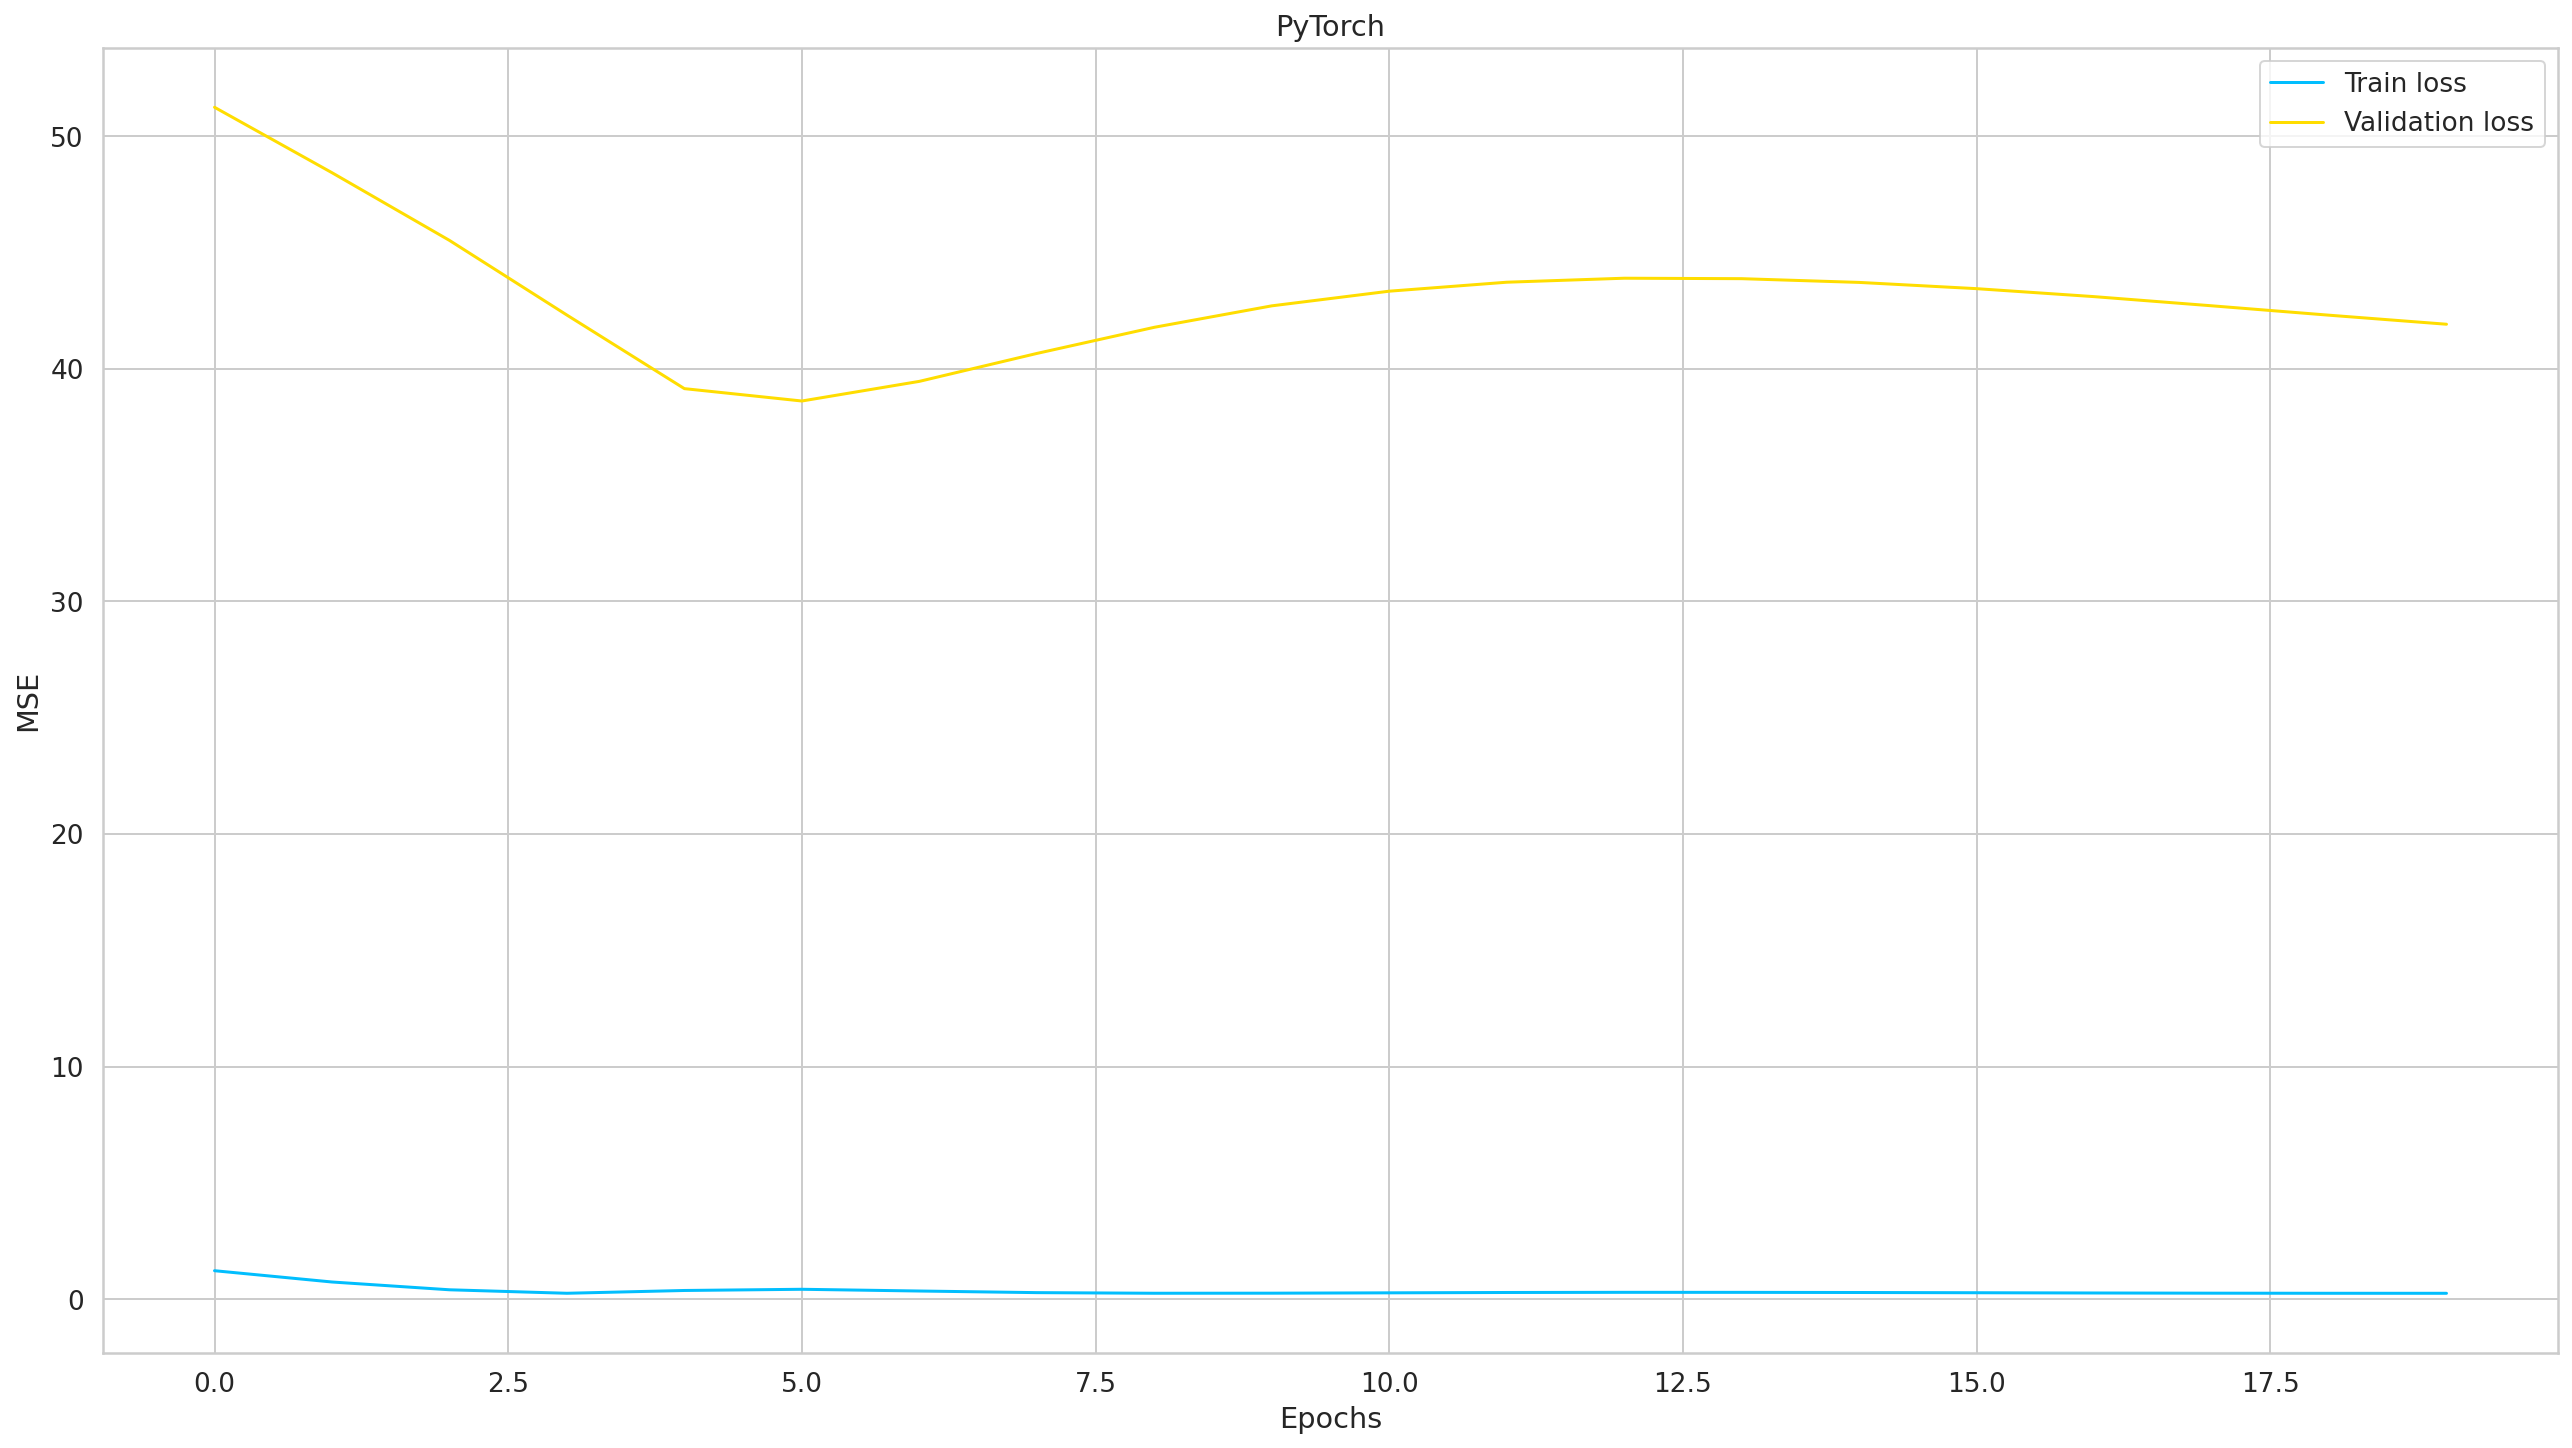

In [47]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

plt.figure(figsize = (22,12))
plt.plot(train_hist, label='Train loss')
plt.plot(test_hist, label='Validation loss')
plt.legend(loc='best')
plt.title('PyTorch')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.show()

### RMSE

#### MLP

In [48]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 0.05982185263800272
Validation rmse: 0.05882575687127716


#### CNN

In [49]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 0.028295466249556228
Validation rmse: 0.02532611079646128


#### LSTM

In [50]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 0.014583168707014538
Validation rmse: 0.02532611079646128


#### CNN - LSTM

In [51]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 0.01448616171818048
Validation rmse: 0.005838083017825615


#### PyTorch

In [52]:
print('Train rmse:', np.sqrt(mean_squared_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0]))))
print('Validation rmse:', np.sqrt(mean_squared_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0]))))

Train rmse: 0.08478568
Validation rmse: 1.2948046


### Mean Absolute Error

#### MLP

In [53]:
print('Train mae:', mean_absolute_error(Y_train, mlp_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, mlp_valid_pred))

Train mae: 0.05328507931172184
Validation mae: 0.052626081208752146


#### CNN

In [54]:
print('Train mae:', mean_absolute_error(Y_train, cnn_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, cnn_valid_pred))

Train mae: 0.02147201022079228
Validation mae: 0.021486591396778436


#### LSTM

In [55]:
print('Train mae:', mean_absolute_error(Y_train, lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, lstm_valid_pred))

Train mae: 0.006229735830799478
Validation mae: 0.021486591396778436


#### CNN-LSTM

In [56]:
print('Train mae:', mean_absolute_error(Y_train, cnn_lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, cnn_lstm_valid_pred))

Train mae: 0.0018639910132868596
Validation mae: 0.0016017509633224312


#### PyTorch

In [57]:
print('Train mae:', mean_absolute_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0])))
print('Validation mae:', mean_absolute_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0])))

Train mae: 0.049153265
Validation mae: 1.0141432


### Mean Absolute Percentage Error

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred/y_true)) * 100

#### MLP

In [59]:
print('Train mape:', mean_absolute_percentage_error(Y_train, mlp_train_pred))
print('Validation mape:', mean_absolute_percentage_error(Y_valid, mlp_valid_pred))

Train mape: 10327.779773234295
Validation mape: 10080.068497611537


#### CNN

In [60]:
print('Train mae:', mean_absolute_percentage_error(Y_train, cnn_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, cnn_valid_pred))

Train mae: 3895.932331524485
Validation mae: 3834.53836921299


#### LSTM

In [61]:
print('Train mae:', mean_absolute_percentage_error(Y_train, lstm_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, lstm_valid_pred))

Train mae: 1244.223980448206
Validation mae: 3834.53836921299


#### CNN-LSTM

In [62]:
print('Train mae:', mean_absolute_percentage_error(Y_train, cnn_lstm_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, cnn_lstm_valid_pred))

Train mae: 268.3197162323687
Validation mae: 252.06868966656333


#### PyTorch

In [63]:
print('Train mae:', mean_absolute_percentage_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0])))
print('Validation mae:', mean_absolute_percentage_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0])))

Train mae: 91.2947952747345
Validation mae: 111.68197393417358
